In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import dataset_utils
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import MSELoss
import tqdm.notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import itertools
# from torch.autograd import Variable
from collections import defaultdict
from Utils import MAPE, RMSELoss, EarlyStopper

In [6]:
def visualize_plot(dictionary, title=None, log=False):
    if log:
        plt.yscale('log')
    for label, elem in dictionary.items():
        plt.plot(elem, label=label)
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()

def visualize_subplots(dictionary, log=False, clip_first=0, dilation=0):
    n = len(dictionary)
    # plt.rcParams["figure.figsize"] = (20,3)
#     f.set_figheight(15)
# f.set_figwidth(15)
    plt.figure(figsize=(16, 7))
    for i, (key, value) in enumerate(dictionary.items()):
        plt.subplot(1, n, i+1)
        for label, elem in value.items():
            len_x = len(elem)
            x = np.arange(len_x)
            x = x[int(len_x * clip_first):]
            elem = elem[int(len_x * clip_first):]
            if dilation > 0:
                tmp_len = int(dilation * len_x)
                elem = np.array(elem[:len(elem) - len(elem) % tmp_len]).reshape(-1, tmp_len).mean(axis=1)
                x = np.array(x[:len(x) - len(x) % tmp_len]).reshape(-1, tmp_len).mean(axis=1)
#                 elem = elem[::int(dilation * len_x)]
#                 x = x[::int(dilation * len_x)]
            plt.plot(x, elem, label=label)
        if log:
            plt.yscale('symlog')
        plt.title(key)
        plt.legend()
    
    plt.plot()

In [7]:
def global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

SEED = 42    
global_seed(seed=SEED)

In [8]:
soft = ['35_21_1000.Q.KatKlD.1444.octanI', '35_21_1000.Q.KatKlAB.DavNpar', '35_21_1000.Q.KatKlAB.EBen70', '35_21_1000.Q.KatKlAB.AroPf.v']

In [9]:
# N, M = 100, 2
# dataset_x = np.random.normal(loc=0, scale=1, size=(N, M)).astype(float)
# dataset_y = np.array([x[0] ** 2 + 9.3 * x[1] - 4 * x[0] * x[1] + 10 for x in dataset_x], dtype=float)
# # dataset_y = np.array([x[0] * 2 - x[1] * 3 + 10 for x in dataset_x])
# dataset_x[0], dataset_y[0]

In [10]:
class Generator(nn.Module):
    def __init__(self, input_shape=1, output_shape=2):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, output_shape),
        )
    
    def forward(self, z, y=None):
        # z - noise
        # print(z.shape, y.shape, z.dtype, y.dtype)
        if y is not None:
            z = torch.stack((z, y), dim=1)
        x = self.layers(z)
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=2):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_shape, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid() 
        )
    def forward(self, x, y=None):
        if y is not None:
            x = torch.cat((x, y[:, None]), dim=1)
        x = self.layers(x).flatten()
        return x

In [152]:
class Regressor(nn.Module):
    def __init__(self, input_shape=1):
        super(Regressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
        )
    def forward(self, x):
        x = self.layers(x).flatten()
        return x

In [207]:
def compute_metrics(x, y, R, y_scaler=None):
    x = torch.tensor(x, dtype=torch.float32).cpu()
    y = torch.tensor(y, dtype=torch.float32).cpu().detach().numpy()
    R = R.cpu()
    y_pred = R(x).detach().numpy()
    if y_scaler is not None:
        y_pred = y_scaler.inverse_transform(y_pred)
        y = y_scaler.inverse_transform(y)
    answer = {}
    answer['RMSE'] = rmse(y_pred, y)
    answer['R2'] = r2_score(y, y_pred)
    answer['MAE'] = np.mean(np.abs(y - y_pred))
    return answer

In [216]:
soft = ['35_21_1000.Q.KatKlD.1444.octanI', '35_21_1000.Q.KatKlAB.DavNpar', '35_21_1000.Q.KatKlAB.EBen70', '35_21_1000.Q.KatKlAB.AroPf.v']
K = 60 #усреднение
SOFT_SENSOR_INDEX = 1
SOFT_SENSOR_NAME = soft[SOFT_SENSOR_INDEX]

In [14]:
data = pd.read_csv("Dataset1_nans.csv", sep=";")

In [15]:
soft_data = data[soft].copy()
data_orig = data.drop(soft + ['Timestamp'], axis=1)

In [16]:
del data

In [17]:
rmse = RMSELoss()


In [81]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 3)

print(type(device), device)

<class 'torch.device'> cuda:3


In [221]:
dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], K=K, diff=False)
dataset_x, dataset_y, _ = dataset.window_view(W=1, scale_target=False)
y_scaler = dataset_utils.MyStandardScaler()
dataset_y = y_scaler.fit_transform(dataset_y)
dataset_x = dataset_x[:, 0, :]

(843, 1, 57) (843,)


In [222]:
dataset_y.shape

(843,)

In [223]:
dataset_x.shape

(843, 57)

In [224]:
mask_train, mask_test = train_test_split(np.arange(dataset_x.shape[0]), shuffle=False, train_size=0.7)
# train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, shuffle=False, train_size=0.7)
train_x, test_x, train_y, test_y = dataset_x[mask_train], dataset_x[mask_test], dataset_y[mask_train], dataset_y[mask_test]

In [225]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((590, 57), (590,), (253, 57), (253,))

In [24]:
type(train_y)

numpy.ndarray

In [25]:
# dataloader = DataLoader(np.arange(train_x.shape[0]), batch_size=4, shuffle=True)

In [121]:
def train_gen(z, x, y, G, D, G_loss, G_opt, labels_true, labels_fake):
    G_opt.zero_grad()
    x_g = G(z, y)
    D_pred_fake = D(x_g, y=y)
    loss_G = G_loss(D_pred_fake, labels_true)
    loss_G.backward()
    G_opt.step()
    return loss_G.cpu().detach().numpy()

def train_dis(z, x, y, G, D, R, D_loss, D_opt, labels_true, labels_fake):
    D_opt.zero_grad()
    x_g = G(z, y)
    y_g = R(x_g).flatten()
    D_pred = D(torch.cat((x, x_g), dim=0), y=torch.cat((y, y_g), dim=0))
#     D_pred = D(torch.cat((x, x_g), dim=0), y=torch.cat((y, y), dim=0))
    labels = torch.cat((labels_true, labels_fake), dim=0)
    loss_D = D_loss(D_pred, labels)
    loss_D.backward()
    D_opt.step()
    return loss_D.cpu().detach().numpy()

def train_reg(x, y, R, R_loss, R_opt):
    R_opt.zero_grad()
    y_pred = R(x)
    loss_R = R_loss(y_pred, y)
    loss_R.backward()
    R_opt.step()
    return loss_R.cpu().detach().numpy()

In [122]:
def eval_gen(z, x, y, G, D, G_loss, labels_true, labels_fake):
    with torch.no_grad():
        x_g = G(z, y)
        D_pred_fake = D(x_g, y=y)
        loss_G = G_loss(D_pred_fake, labels_true)
        return loss_G.cpu().detach().numpy()

def eval_dis(z, x, y, G, D, R, D_loss, labels_true, labels_fake):
    with torch.no_grad():
        x_g = G(z, y)
        y_g = R(x_g).flatten()
        D_pred = D(torch.cat((x, x_g), dim=0), y=torch.cat((y, y_g), dim=0))
#         D_pred = D(torch.cat((x, x_g), dim=0), y=torch.cat((y, y), dim=0))
        labels = torch.cat((labels_true, labels_fake), dim=0)
        loss_D = D_loss(D_pred, labels)
        return loss_D.cpu().detach().numpy()
    

def eval_reg(x, y, R, R_loss):
    with torch.no_grad():
        y_pred = R(x)
        loss_R = R_loss(y_pred, y)
        return loss_R.cpu().detach().numpy()

In [38]:
def apply_model(model, data_x, scaler=None):
    model.eval()
    with torch.no_grad():
        if not torch.is_tensor(data_x):
            data_x = torch.tensor(data_x)
        inputs = data_x.float()
        outputs = model(inputs).cpu().detach().numpy()
    if scaler is not None:
        outputs = scaler.inverse_transform(outputs)
    return outputs

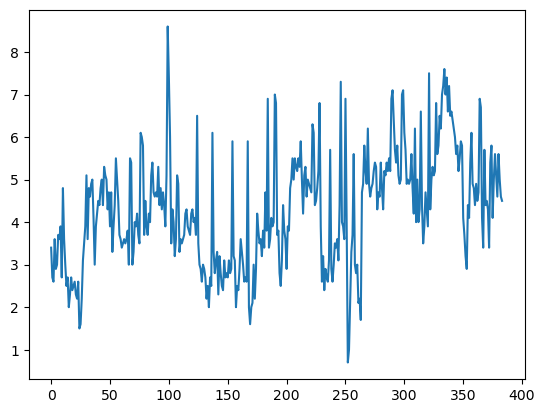

In [29]:
plt.plot(test_y)

In [36]:
def save_models(D=None, G=None, R=None, path=""):
    torch.save(G.state_dict(), path + "_G.pth")    
    torch.save(D.state_dict(), path + "_D.pth")
    torch.save(R.state_dict(), path + "_R.pth")    

In [148]:
def train(train_x, train_y, test_x, test_y, epoches=5, n_gen=1, n_dis=1, n_reg=1, train_on_real=True, \
          G=None, D=None, R=None, save_plots_test=None): #1 for real data
    if G is  None:
        G = Generator(input_shape=2, output_shape=train_x.shape[-1])
        D = Discriminator(input_shape=train_x.shape[-1] + 1)
        R = Regressor(input_shape=train_x.shape[-1])
    G.to(device); R.to(device); D.to(device)

    G_opt = torch.optim.Adam(G.parameters(), lr=1e-4)
    D_opt = torch.optim.Adam(D.parameters(), lr=5e-5)
    R_opt = torch.optim.Adam(R.parameters(), lr=1e-4)

    losses_log = {"Regressor":defaultdict(list), "Discriminator":defaultdict(list), "Generator":defaultdict(list)}

    D_loss = nn.BCELoss()
    G_loss = nn.BCELoss()
    R_loss = nn.MSELoss()
    
    train_x, train_y, test_x, test_y = [torch.tensor(tmp, dtype=torch.float32).to(device) for tmp in \
                                        (train_x, train_y, test_x, test_y)]
    dataloader = DataLoader(np.arange(train_x.shape[0]), batch_size=4, shuffle=True)
    for epoch in range(epoches):
        D_run_loss, G_run_loss, R_run_loss_real, R_run_loss_fake = 0, 0, 0, 0
        D.train(); G.train(); R.train()
        #Regressor
        for it in range(n_reg):
            for ids in dataloader:
                x, y = train_x[ids], train_y[ids]
                labels_true = torch.ones(x.shape[0], dtype=torch.float32).to(device)
                labels_fake = torch.zeros(x.shape[0], dtype=torch.float32).to(device)
                z = torch.normal(0, 1, size=(x.shape[0],), dtype=torch.float32).to(device)
                if train_on_real:
                    loss_R_real = train_reg(x, y, R, R_loss, R_opt)
                    R_run_loss_real += loss_R_real
                x_g = G(z, y)
                loss_R_fake = train_reg(x_g, y, R, R_loss, R_opt)
                R_run_loss_fake += loss_R_fake

            
        #Discriminator
        for it in range(n_dis):
            for ids in dataloader:
                x, y = train_x[ids], train_y[ids]
                labels_true = torch.ones(x.shape[0], dtype=torch.float32).to(device)
                labels_fake = torch.zeros(x.shape[0], dtype=torch.float32).to(device)
                z = torch.normal(0, 1, size=(x.shape[0],), dtype=torch.float32).to(device)
                loss_D = train_dis(z, x, y, G, D, R, D_loss, D_opt, labels_true, labels_fake)
                #interpolated не сделала
                D_run_loss += loss_D

        
        #Generator
        for it in range(n_gen):
            for ids in dataloader:
                x, y = train_x[ids], train_y[ids]
                labels_true = torch.ones(x.shape[0], dtype=torch.float32).to(device)
                labels_fake = torch.zeros(x.shape[0], dtype=torch.float32).to(device)
                
                z = torch.normal(0, 1, size=(x.shape[0],), dtype=torch.float32).to(device)
                loss_G = train_gen(z, x, y, G, D, G_loss, G_opt, labels_true, labels_fake)
                G_run_loss += loss_G
        
        losses_log['Discriminator']['train'].append(D_run_loss / len(dataloader) / n_dis)
        losses_log['Generator']['train'].append(G_run_loss / len(dataloader) / n_gen)
        losses_log['Regressor']['train_fake'].append(R_run_loss_fake / len(dataloader) / n_reg)
        if train_on_real:
            losses_log['Regressor']['train_real'].append(R_run_loss_real / len(dataloader) / n_reg)

        #validation
        D.eval(); G.eval(); R.eval()
        with torch.no_grad():
            x = torch.tensor(test_x, dtype=torch.float32).to(device)
            y = torch.tensor(test_y, dtype=torch.float32).to(device)
            labels_true = torch.ones(x.shape[0], dtype=torch.float32).to(device)
            labels_fake = torch.zeros(x.shape[0], dtype=torch.float32).to(device)

            z = torch.normal(0, 1, size=(x.shape[0],), dtype=torch.float32).to(device)
            loss_G = eval_gen(z, x, y, G, D, G_loss, labels_true, labels_fake)
            loss_D = eval_dis(z, x, y, G, D, R, D_loss, labels_true, labels_fake)
            loss_R = eval_reg(x, y, R, R_loss)
            # x_g = G(z, y)
            # D_pred_fake = D(x_g, y)
            # D_pred_true = D(x, y)
            # labels_true = torch.ones(x.shape[0], dtype=torch.float32)
            # labels_fake = torch.zeros(x_g.shape[0], dtype=torch.float32) #1 for true
            # loss_G = G_loss(D_pred_fake, labels_true)

            # D_pred = D(torch.cat((x, x_g), dim=0), y.repeat(2))
            # labels = torch.cat((labels_fake, labels_true), dim=0)

            losses_log['Generator']['valid'].append(loss_G)
            losses_log['Discriminator']['valid'].append(loss_D)
            losses_log['Regressor']['valid'].append(loss_R)
            if save_plots_test is not None:
                y_pred = apply_model(R, test_x)
                plt.plot(test_y.cpu().detach().numpy(), color="blue")
                plt.plot(y_pred, color="orange")
                y_min, y_max = float(torch.min(test_y) - torch.std(test_y)), float(torch.max(test_y) + torch.std(test_y))
                plt.ylim((y_min, y_max))
                plt.savefig(save_plots_test + f"{epoch:03d}" + '.png', bbox_inches='tight')
                plt.title(f"{epoch:03d}")
                plt.clf()
        if epoch % 20 == 0:
            print(f"EPOCH : {epoch}")
    D.cpu(), G.cpu(), R.cpu()
    return D, G, R, losses_log

In [201]:
def write_table(R, dataset_x, dataset_y, mask_train=None, mask_test=None, path=None, y_scaler=None):
    y_pred = apply_model(R, dataset_x)
    if y_scaler is not None:
        y_pred = y_scaler.inverse_transform(y_pred)
        dataset_y = y_scaler.inverse_transform(dataset_y)
    
    mask = np.zeros(dataset_x.shape[0])
    mask[mask_train] = 0 #TRAIN
    mask[mask_test] = 2 #TEST
    if path is None:
        path = f"gan_results/table_{SOFT_SENSOR_INDEX}.csv"
    table = pd.DataFrame(np.stack((dataset_y, y_pred, mask), axis=1), \
                         columns= ['y', 'y_pred', 'mode'])
    table.to_csv(path)

In [217]:
%%time
global_seed(42)
D, G, R, losses = train(train_x, train_y, test_x, test_y, epoches=80, train_on_real=True, \
                        n_gen=15, n_dis=10, n_reg=1) #, save_plots_test="gan_results/plots/")

/tmp/ipykernel_1714459/3456962048.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(test_x, dtype=torch.float32).to(device)
/tmp/ipykernel_1714459/3456962048.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(test_y, dtype=torch.float32).to(device)


EPOCH : 0
EPOCH : 20
EPOCH : 40
EPOCH : 60
CPU times: user 27min 11s, sys: 6.84 s, total: 27min 18s
Wall time: 27min 8s


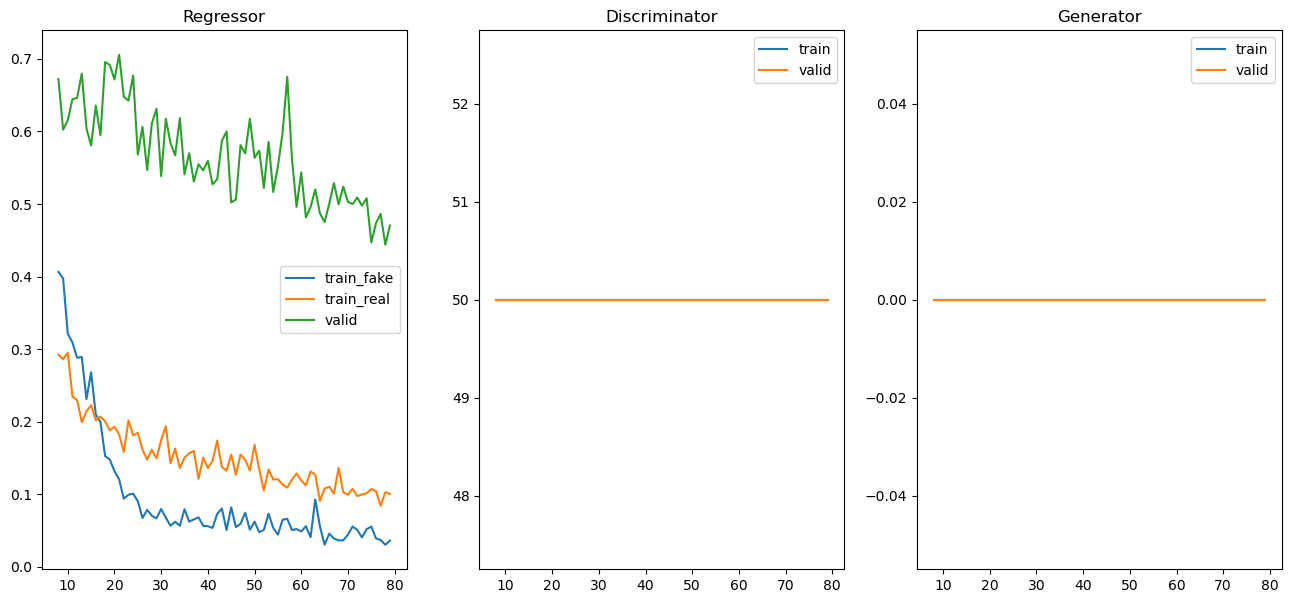

In [219]:
visualize_subplots(losses, log=False, clip_first=0.1, dilation=0)

In [181]:
import pickle
with open("gan_results/losses", "wb") as f:
    pickle.dump(losses, f)

In [162]:
%%time
global_seed(42)
D1, G1, R1, losses1 = train(train_x, train_y, test_x, test_y, epoches=20, train_on_real=False, \
                        n_gen=15, n_dis=10, n_reg=1, R=R, G=G, D=D) #, save_plots_test="gan_results/plots/")

/tmp/ipykernel_1714459/3456962048.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(test_x, dtype=torch.float32).to(device)
/tmp/ipykernel_1714459/3456962048.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(test_y, dtype=torch.float32).to(device)


EPOCH : 0
CPU times: user 7min 12s, sys: 1.82 s, total: 7min 14s
Wall time: 7min 7s


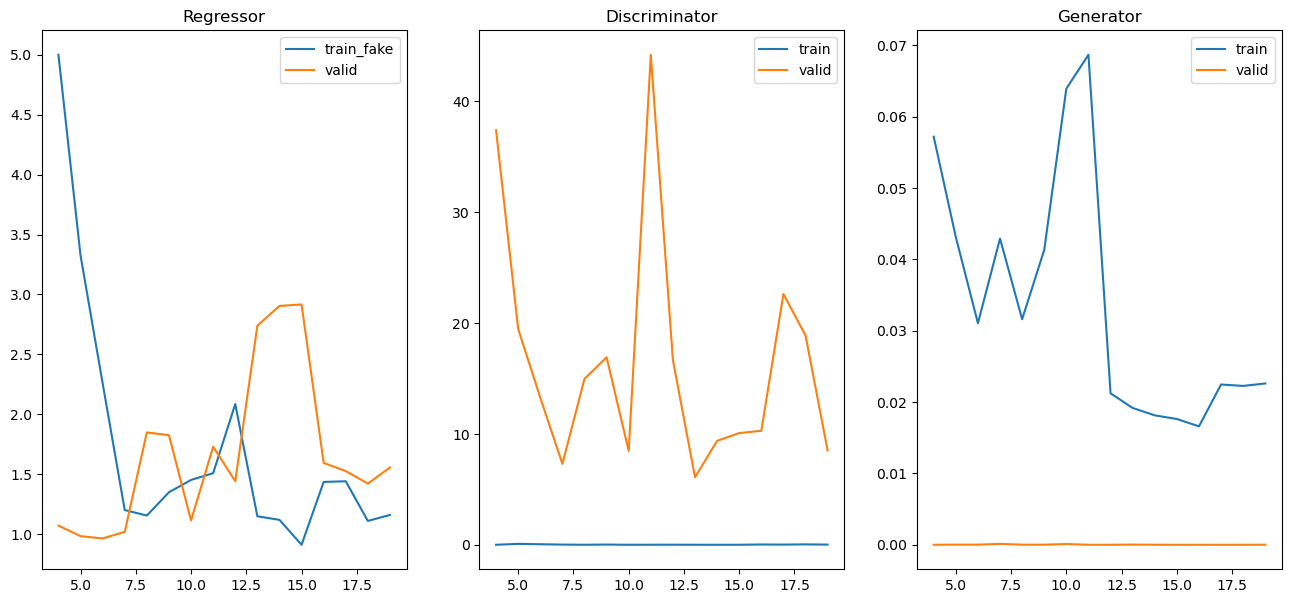

In [163]:
visualize_subplots(losses1, log=False, clip_first=0.2, dilation=0)

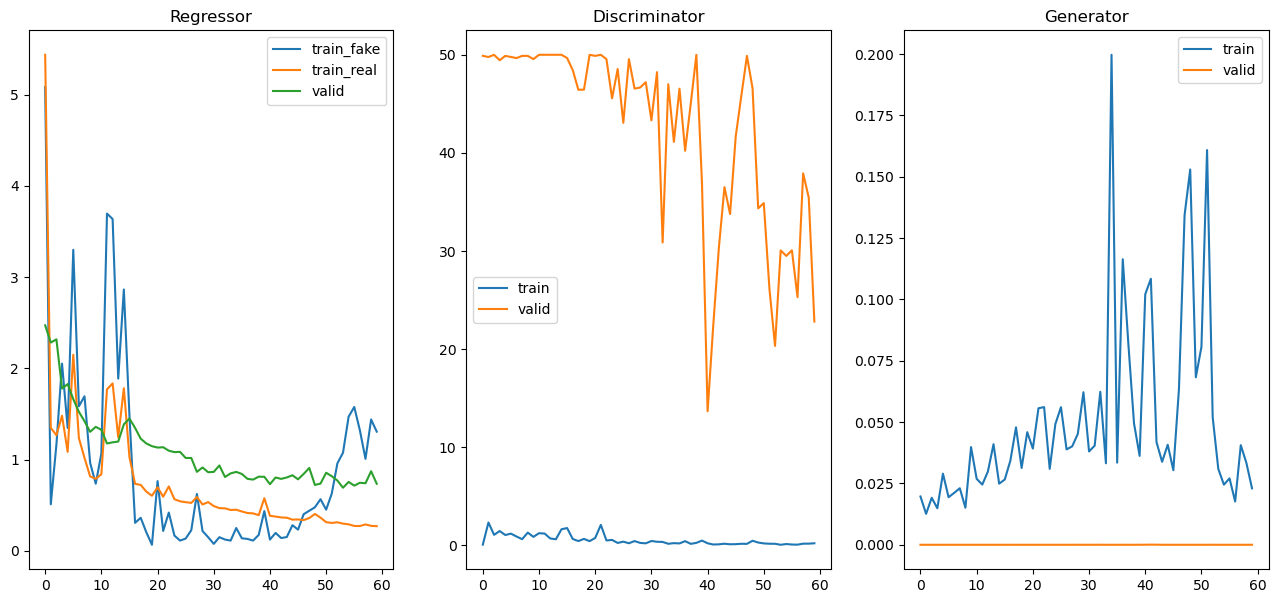

In [124]:
visualize_subplots(losses, log=False, clip_first=0, dilation=0)

In [215]:
save_models(R=R, G=G, D=D, path='gan_results/models/{0}_1'.format(SOFT_SENSOR_INDEX))

In [214]:
'gan_results/table_{0}-1.csv'.format(SOFT_SENSOR_INDEX)

'gan_results/table_0-1.csv'

In [212]:
write_table(R, dataset_x, dataset_y, mask_train=mask_train, mask_test=mask_test, \
            path='gan_results/table_{0}-1.csv'.format(SOFT_SENSOR_INDEX), y_scaler=y_scaler)

In [220]:
test_metrics = compute_metrics(test_x, test_y, R, y_scaler=y_scaler)
test_metrics

{'RMSE': tensor(1.1924), 'R2': 0.48574456762639573, 'MAE': 0.93209386}

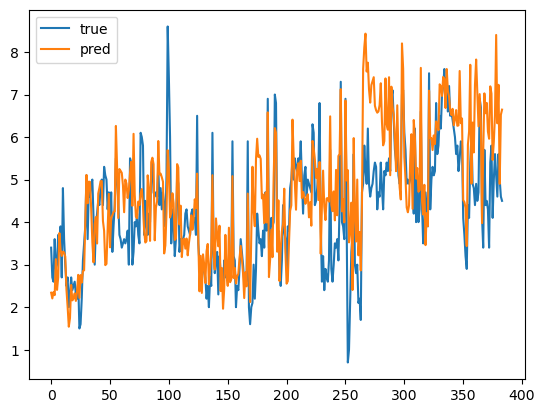

In [243]:
plt.plot(test_y, label='true')
y_pred = apply_model(R3_tuned, test_x)
plt.plot(y_pred, label="pred", color="orange")
plt.legend()
plt.show()

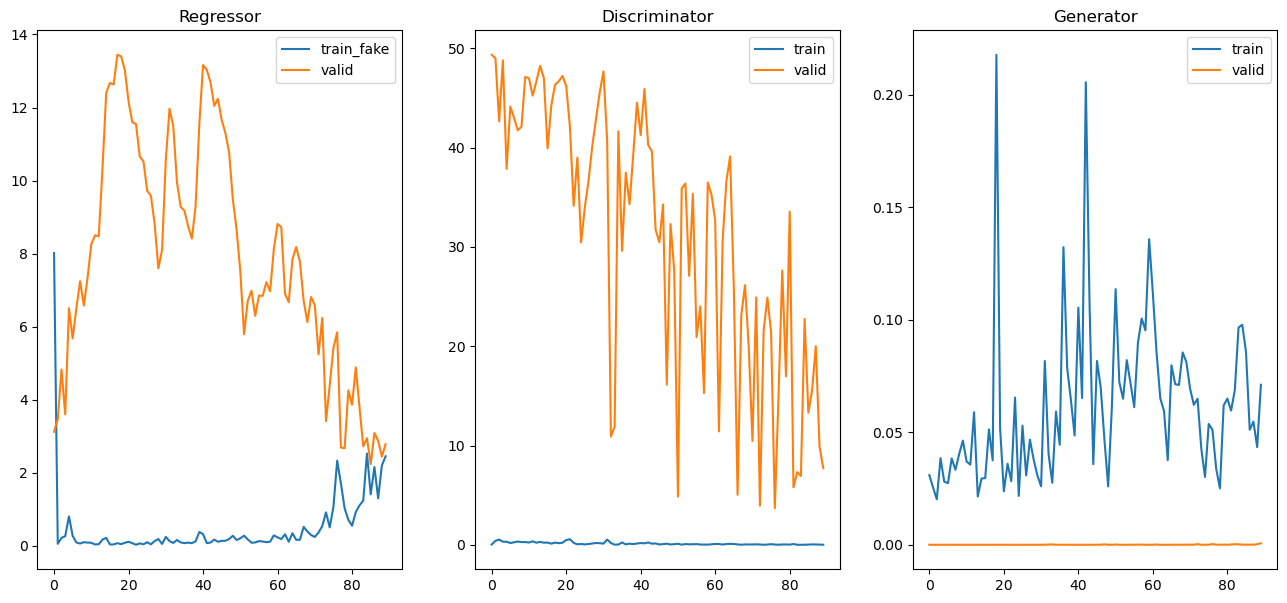

In [220]:
visualize_subplots(losses3, log=False, clip_first=0, dilation=0)

In [221]:
test_metrics = compute_metrics(test_x, test_y, R3)
test_metrics

{'RMSE': tensor(1.6677), 'R2': -0.5474049781627186, 'MAE': 1.3781061}

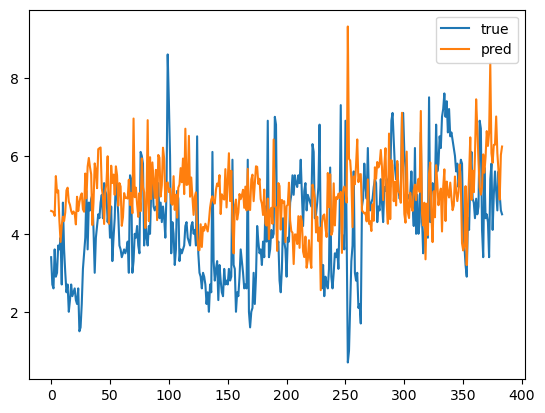

In [222]:
plt.plot(test_y, label="true")
y_pred = R3(torch.tensor(test_x).float())
plt.plot(y_pred.detach().numpy(), label="pred")
plt.legend()
plt.show()

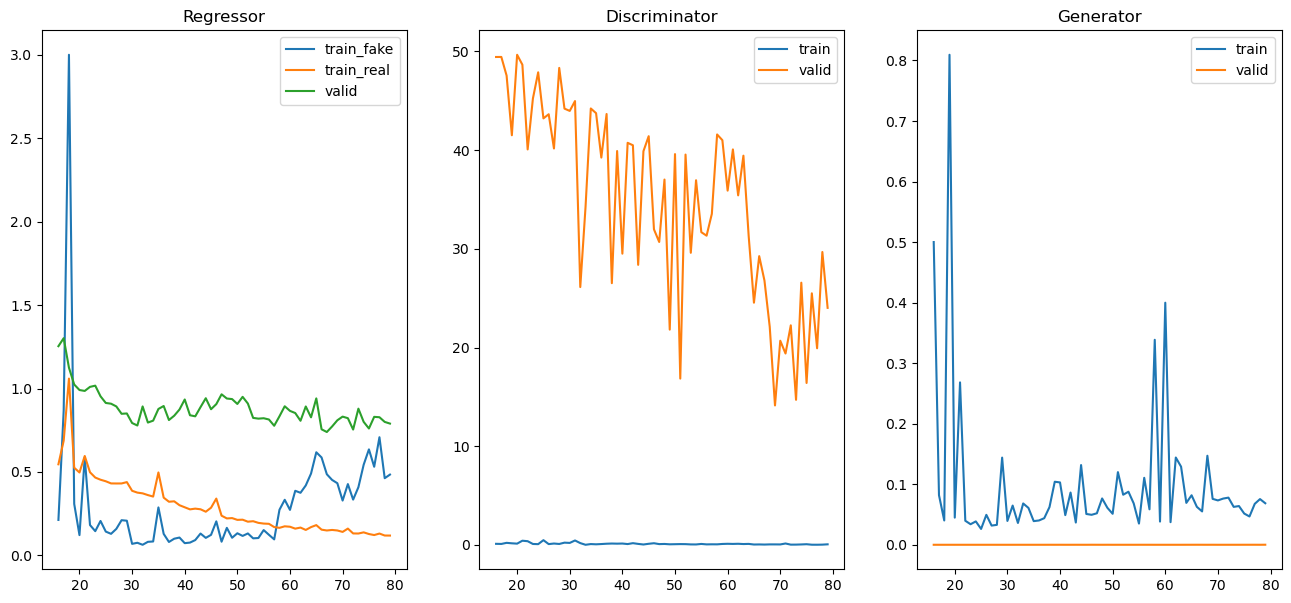

In [207]:
visualize_subplots(losses3, log=False, clip_first=0.2, dilation=0)

In [208]:
test_metrics = compute_metrics(test_x, test_y, R3)
test_metrics

{'RMSE': tensor(0.8887), 'R2': 0.5605292176361049, 'MAE': 0.7029467}

In [205]:
test_metrics = compute_metrics(test_x, test_y, R3)
test_metrics

{'RMSE': tensor(0.9349), 'R2': 0.5136596439943302, 'MAE': 0.67963386}

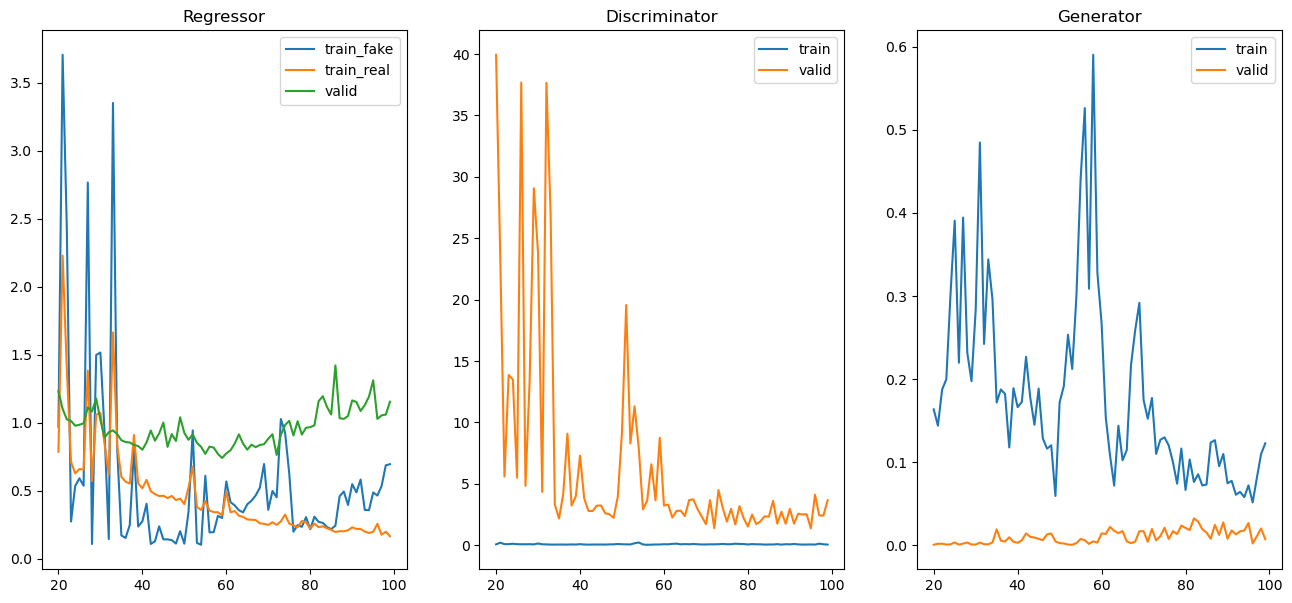

In [195]:
#100, 3, 3, 1
visualize_subplots(losses3, log=False, clip_first=0.2, dilation=0)

In [197]:
test_metrics = compute_metrics(test_x, test_y, R3)
test_metrics

{'RMSE': tensor(1.0743), 'R2': 0.35781231891836085, 'MAE': 0.82459575}

In [187]:
%%time
global_seed(42)
D, G, R2, losses2 = train(train_x, train_y, test_x, test_y, epoches=100, train_on_real=True, \
                        n_gen=5, n_dis=5, n_reg=1)

/tmp/ipykernel_3469/2105870099.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(test_x, dtype=torch.float32).to(device)
/tmp/ipykernel_3469/2105870099.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(test_y, dtype=torch.float32).to(device)


EPOCH : 0
EPOCH : 20
EPOCH : 40
EPOCH : 60
EPOCH : 80
CPU times: user 15min 25s, sys: 3.82 s, total: 15min 29s
Wall time: 15min 26s


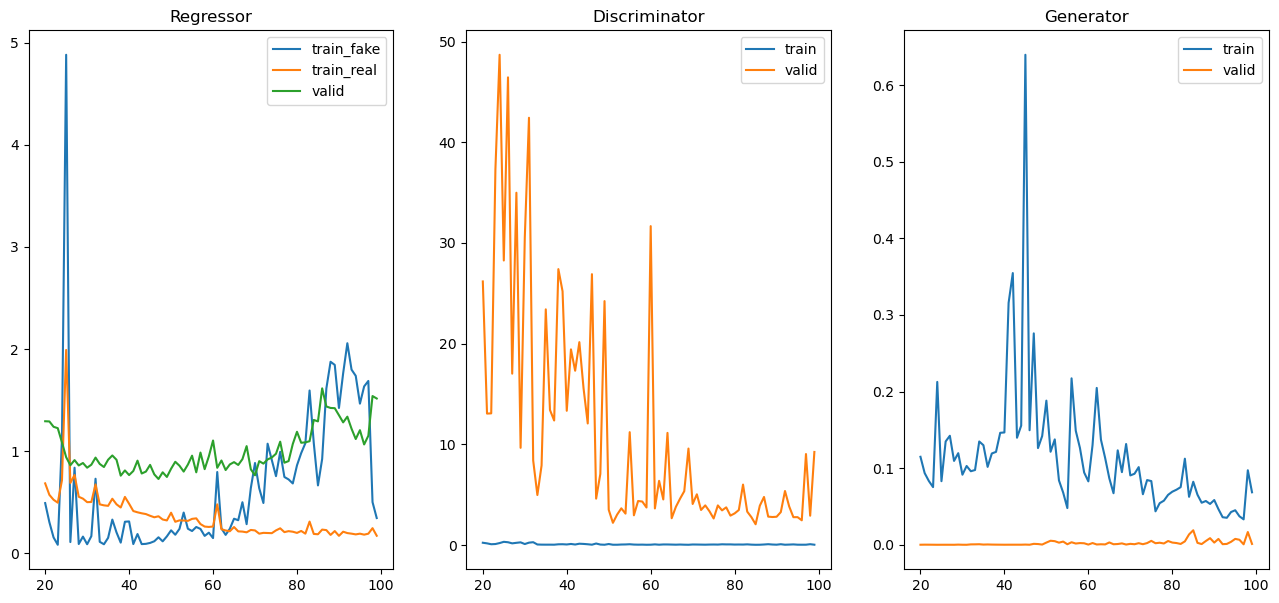

In [191]:
visualize_subplots(losses2, log=False, clip_first=0.2, dilation=0)

In [192]:
test_metrics = compute_metrics(test_x, test_y, R2)
test_metrics

{'RMSE': tensor(1.2313), 'R2': 0.1564178592687393, 'MAE': 0.92026806}

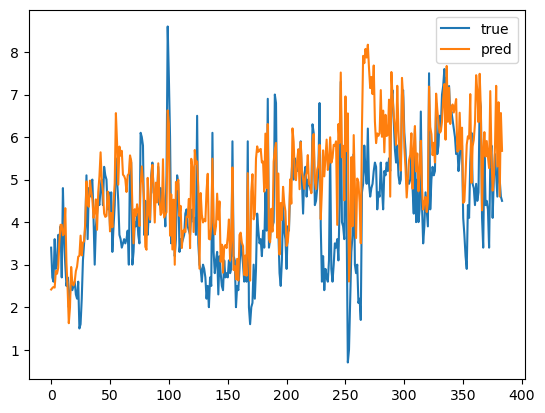

In [193]:
plt.plot(test_y, label="true")
y_pred = R2(torch.tensor(test_x).float())
plt.plot(y_pred.detach().numpy(), label="pred")
plt.legend()
plt.show()

In [ ]:
#Batch Norm, embedding,ансамбль, дообучение на искуственных, графовые модели (интерполяция нужна)

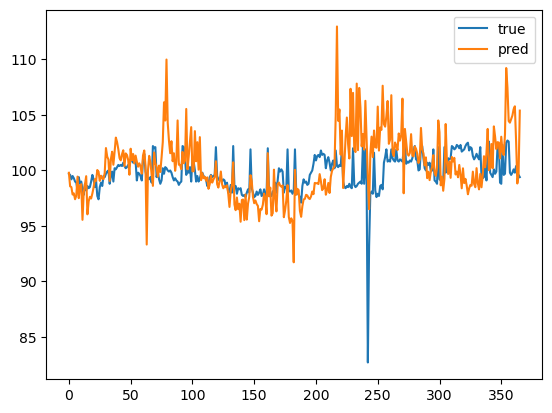

In [160]:
plt.plot(test_y, label="true")
y_pred = R1(torch.tensor(test_x).float())
plt.plot(y_pred.detach().numpy(), label="pred")
plt.legend()
plt.show()

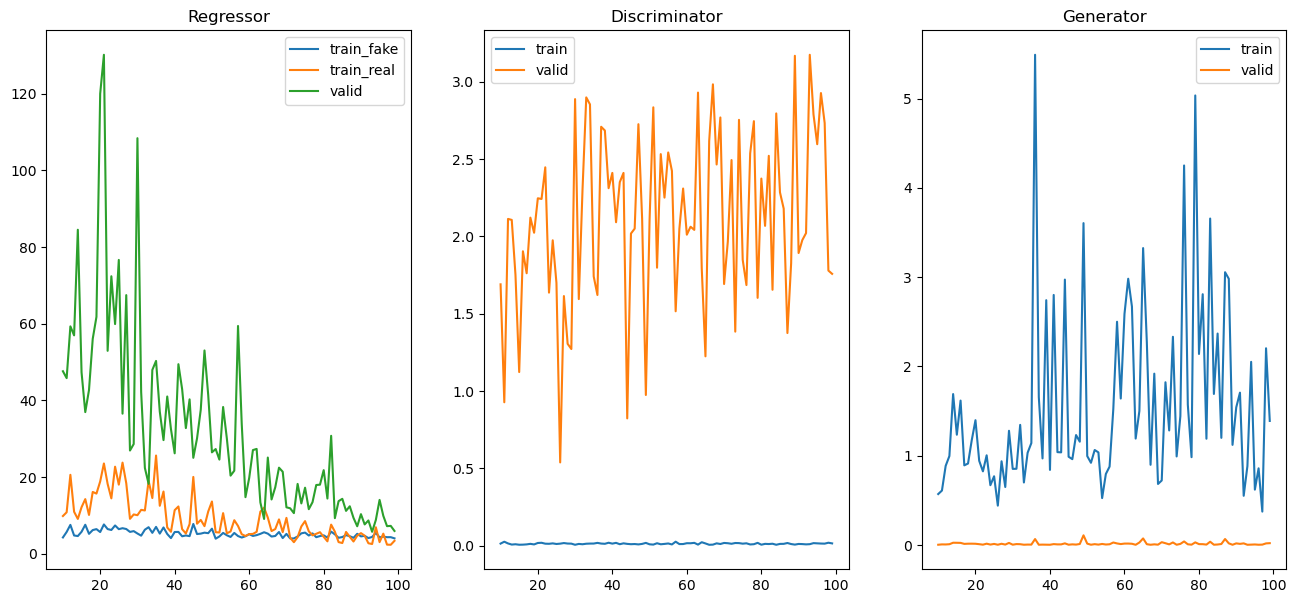

In [151]:
visualize_subplots(losses, log=False, clip_first=0.1, dilation=0)

In [149]:
test_metrics = compute_metrics(test_x, test_y, R)
test_metrics

{'RMSE': tensor(2.4392), 'R2': -1.1518094354907222, 'MAE': 1.732878}

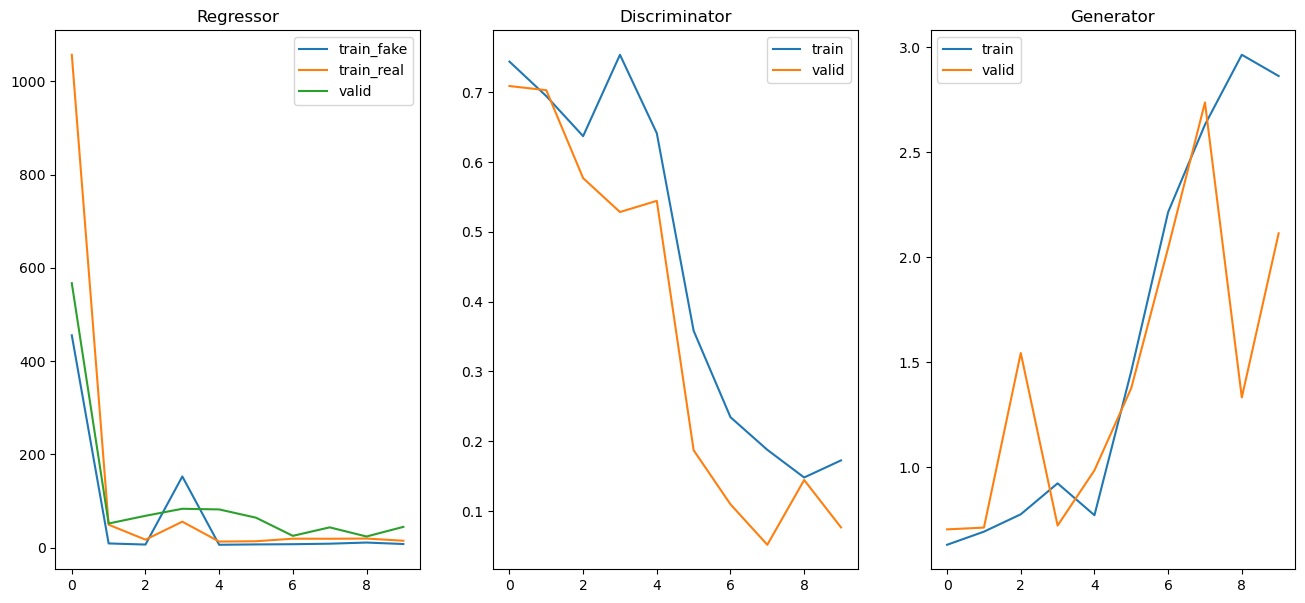

In [46]:
visualize_subplots(losses, log=False, clip_first=0, dilation=0)

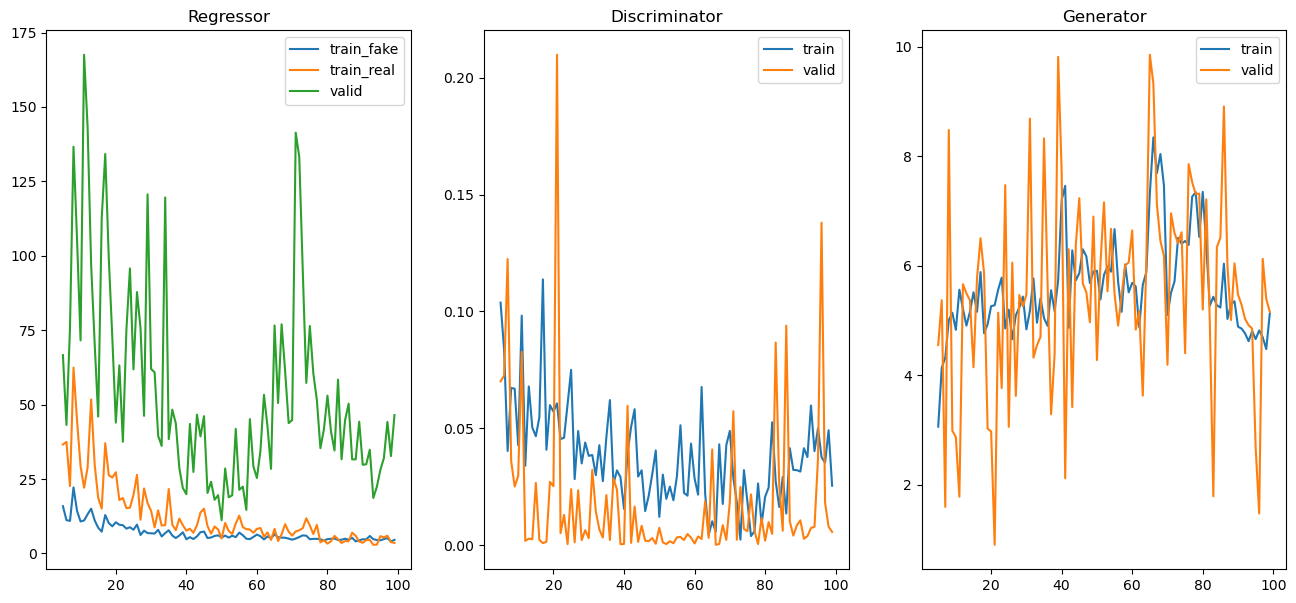

In [163]:
visualize_subplots(losses1, log=False, clip_first=0.05, dilation=0)

In [172]:
x = torch.tensor(test_x, dtype=torch.float32).to(device)
y = torch.tensor(test_y, dtype=torch.float32).to(device)

In [176]:
x_g = G(z=torch.normal(mean=0, std=1, size=(y.shape[0],)).to(device), y=y).cpu().detach().numpy()

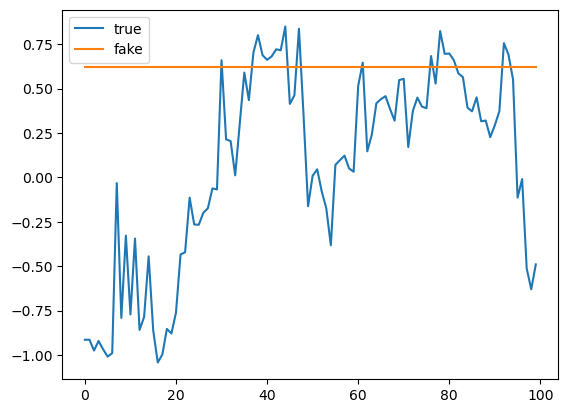

In [177]:
plt.plot(test_x[:100, 3], label="true")
plt.plot(x_g[:100, 3], label='fake')
plt.legend()
plt.show()

<BarContainer object of 59 artists>

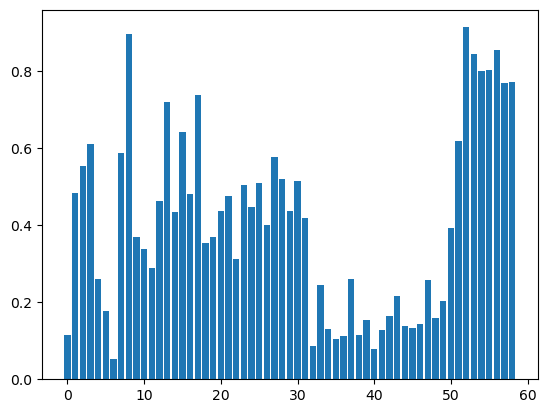

In [178]:
plt.bar(np.arange(test_x.shape[1]), np.mean(np.abs(test_x - x_g), axis=0))

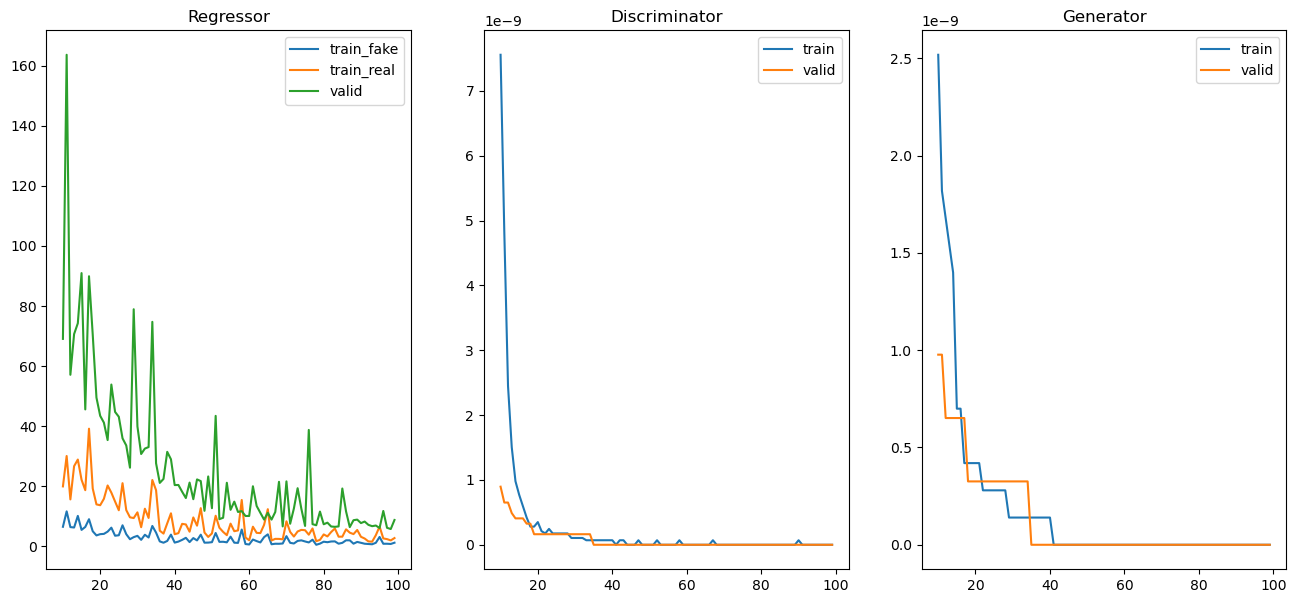

In [88]:
visualize_subplots(losses, log=False, clip_first=0.1)

In [ ]:
#старая версия 
for ids in dataloader:
    x = torch.tensor(train_x[ids], dtype=torch.float32).to(device)
    y = torch.tensor(train_y[ids], dtype=torch.float32).to(device)
    labels_true = torch.ones(x.shape[0], dtype=torch.float32).to(device)
    labels_fake = torch.zeros(x.shape[0], dtype=torch.float32).to(device)

    #Regressor
    z = torch.normal(0, 1, size=(x.shape[0],), dtype=torch.float32).to(device)
    if train_on_real:
        loss_R_real = train_reg(x, y, R, R_loss, R_opt)
        R_run_loss_real += loss_R_real
    x_g = G(z, y)
    loss_R_fake = train_reg(x_g, y, R, R_loss, R_opt)
    # Discriminator
    y_g = R(x_g).flatten()
    loss_D = train_dis(z, x, y, G, D, R, D_loss, D_opt, labels_true, labels_fake)
    #interpolated x не сделала
    
    #Generator
    for n in range(gen_ratio):
        z = torch.normal(0, 1, size=(x.shape[0],), dtype=torch.float32).to(device)
        loss_G = train_gen(z, x, y, G, D, G_loss, G_opt, labels_true, labels_fake)
        G_run_loss += loss_G

    D_run_loss += loss_D
    R_run_loss_fake += loss_R_fake
    # R_run_loss += (((loss_R_fake + loss_R_real) / 2) if train_on_real else loss_R_fake)